# BQM Factorization Machine

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import dimod
from factorization_machine import FactorizationMachine
from torch.utils.data import TensorDataset, DataLoader

### 設定參數

In [11]:
DATASET_SIZE = 10000
TEST_NUM = 50000
RANDOM_SEED = 42
VAR_NUM = 32
K = VAR_NUM
NUM_EPOCH = 1000
LEARNING_RATE = 1e-3
BATCH_SIZE = 512

### 產生 BQM 與資料集

In [12]:
# 產生 BQM
print("Generating BQM...")
def custom_bias_generator(var_num):
    return np.random.uniform(-1, 1, var_num)
bqm = dimod.generators.gnm_random_bqm(
          variables=VAR_NUM,
          num_interactions=VAR_NUM*(VAR_NUM-1)/2,
          vartype=dimod.BINARY,
          bias_generator=custom_bias_generator
      )
print("BQM generated.")

# 產生訓練和測試資料集
print("Generating training and testing datasets...")
xs_train = np.random.randint(0, 2, (DATASET_SIZE, VAR_NUM), dtype=np.int8)
ys_train = np.array([bqm.energy(x) for x in xs_train], dtype=np.float64)

xs_test = np.random.randint(0, 2, (TEST_NUM, VAR_NUM), dtype=np.int8)
ys_test = np.array([bqm.energy(x) for x in xs_test], dtype=np.float64)

os.makedirs("data", exist_ok=True)
np.save("data/xs_train.npy", xs_train)
np.save("data/ys_train.npy", ys_train)
np.save("data/xs_test.npy", xs_test)
np.save("data/ys_test.npy", ys_test)
print("Datasets saved to 'data/' directory.")

Generating BQM...
BQM generated.
Generating training and testing datasets...
Datasets saved to 'data/' directory.


### 初始化模型權重

In [13]:
# 產生並儲存初始權重
print("Generating and saving initial model weights...")
model_py_init = FactorizationMachine(input_size=VAR_NUM, factorization_size=K)

# 提取權重
initial_bias = model_py_init.bias.detach().numpy()
initial_h = model_py_init.h.detach().numpy()
initial_V = model_py_init.V.detach().numpy()

os.makedirs("data", exist_ok=True)
np.save("data/initial_bias.npy", initial_bias)
np.save("data/initial_h.npy", initial_h)
np.save("data/initial_V.npy", initial_V)
print("   Initial weights saved.")
print("\nData generation complete.")

Generating and saving initial model weights...
   Initial weights saved.

Data generation complete.


### 模型訓練 (PyTorch)

In [14]:
print("Loading data and initial weights for PyTorch...")
xs_train = np.load("data/xs_train.npy")
ys_train = np.load("data/ys_train.npy")
xs_test = np.load("data/xs_test.npy")
ys_test = np.load("data/ys_test.npy")

initial_bias = np.load("data/initial_bias.npy")
initial_h = np.load("data/initial_h.npy")
initial_V = np.load("data/initial_V.npy")

# 初始化模型並設定權重
print("Initializing PyTorch model with pre-defined weights...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using device: {device}")

model_py = FactorizationMachine(input_size=VAR_NUM, factorization_size=K, act="identity")

with torch.no_grad():
    model_py.bias.copy_(torch.from_numpy(initial_bias))
    model_py.h.copy_(torch.from_numpy(initial_h))
    model_py.V.copy_(torch.from_numpy(initial_V))
model_py.to(device)

# 訓練模型
print("3. Starting PyTorch training on GPU...")
x_tensor = torch.from_numpy(xs_train).float()
y_tensor = torch.from_numpy(ys_train).float()
train_dataset = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_py.parameters(), lr=LEARNING_RATE)

start_time = time.time()
model_py.train() # 設置為訓練模式
for epoch in range(NUM_EPOCH):
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # 前向傳播
        outputs = model_py(inputs)
        loss = criterion(outputs.squeeze(), labels) # 使用 squeeze() 來匹配維度

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCH}], Loss: {total_loss / len(train_loader):.4f}')

end_time = time.time()
print(f"   Training finished in {end_time - start_time:.2f} seconds.")

Loading data and initial weights for PyTorch...
Initializing PyTorch model with pre-defined weights...
   Using device: cpu
3. Starting PyTorch training on GPU...
Epoch [100/1000], Loss: 0.2625
Epoch [200/1000], Loss: 0.0498
Epoch [300/1000], Loss: 0.0060
Epoch [400/1000], Loss: 0.0004
Epoch [500/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
   Training finished in 63.33 seconds.


### 可視化 Q 矩陣

Extracting BQM from the trained PyTorch model and predicting...
Q matrix plot saved to results/Q_matrix_pytorch.png


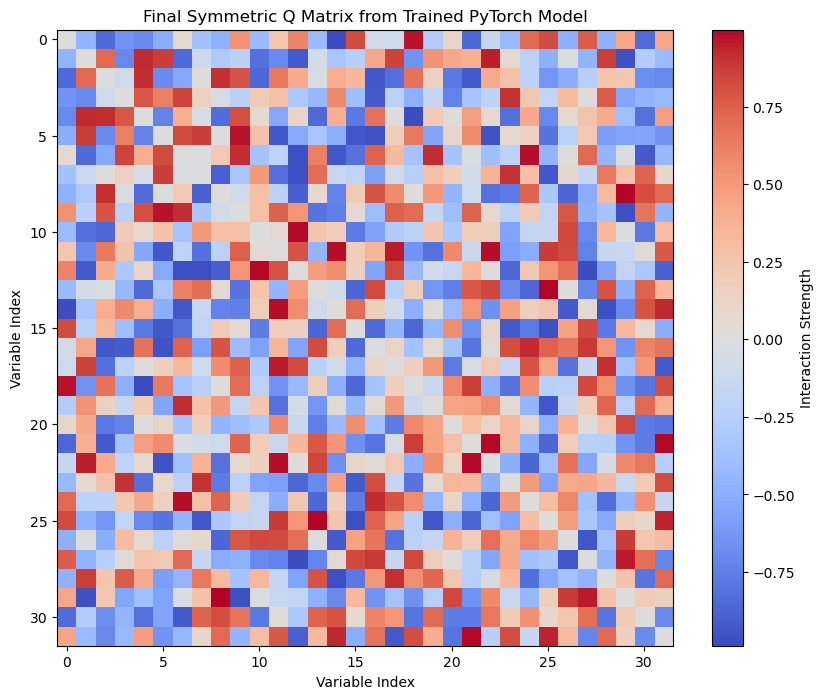

In [15]:
print("Extracting BQM from the trained PyTorch model and predicting...")
model_py.eval() # 設置為評估模式
model_py.cpu()  # 將模型移回 CPU 以便操作 NumPy 和 dimod

b, h, Q_matrix_triu = model_py.get_bhQ()
V_numpy = model_py.V.detach().numpy()
Q_symmetric = V_numpy.T @ V_numpy
np.fill_diagonal(Q_symmetric, 0) # 對角線元素為0

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(Q_symmetric, cmap='coolwarm', interpolation='nearest')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Interaction Strength')
ax.set_title("Final Symmetric Q Matrix from Trained PyTorch Model")
ax.set_xlabel("Variable Index")
ax.set_ylabel("Variable Index")

os.makedirs("results", exist_ok=True)
plt.savefig("results/Q_matrix_pytorch.png")
print("Q matrix plot saved to results/Q_matrix_pytorch.png")

### 預測與結果對比

Saving PyTorch results...

PyTorch script finished.
'energy_comparison.png' saved.


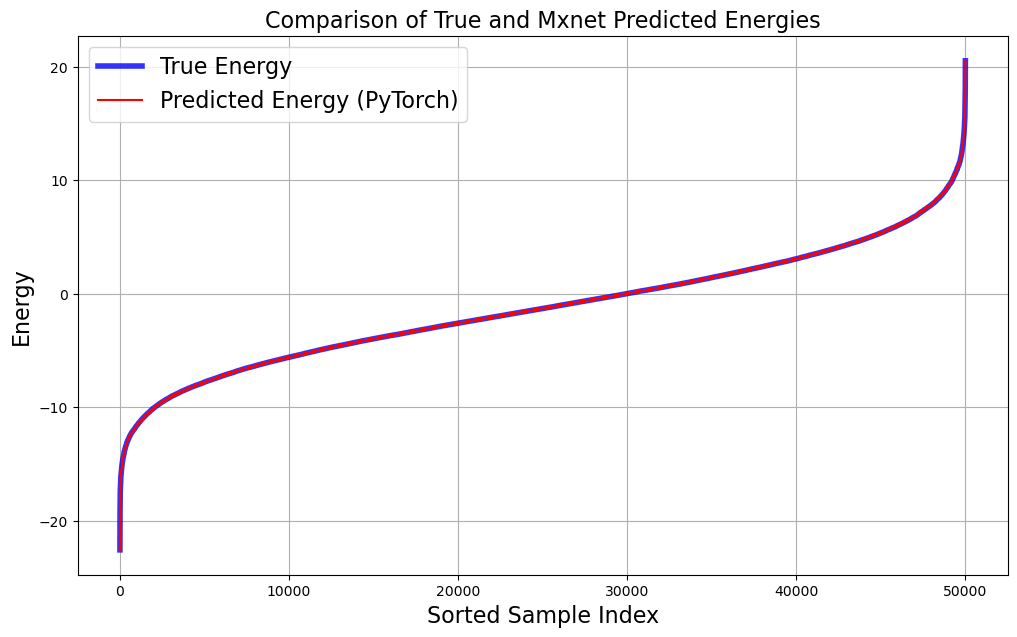

In [16]:
Q_dict = {(i, j): Q_matrix_triu[i, j] for i, j in zip(*np.where(Q_matrix_triu != 0))}
bqm_pred_pt = dimod.BinaryQuadraticModel(h, Q_dict, b, dimod.BINARY)
ys_pred_pytorch = np.array([bqm_pred_pt.energy(x) for x in xs_test], dtype=np.float64)

# 儲存結果
print("Saving PyTorch results...")
np.save("results/ys_pred_pytorch.npy", ys_pred_pytorch)
print("\nPyTorch script finished.")

# 讀取所有結果
ys_test = np.load("data/ys_test.npy")
ys_pred_pytorch = np.load("results/ys_pred_pytorch.npy")

# 繪製能量預測圖
sorted_indices = np.argsort(ys_test)
ys_sorted = ys_test[sorted_indices]
ys_pred_pt_sorted = ys_pred_pytorch[sorted_indices]

plt.figure(figsize=(12, 7))
plt.plot(ys_sorted, color="blue", label="True Energy", linewidth=4, alpha=0.8)
plt.plot(ys_pred_pt_sorted, color="red", label="Predicted Energy (PyTorch)", linestyle='-')
plt.title("Comparison of True and Mxnet Predicted Energies", fontsize=16)
plt.xlabel("Sorted Sample Index", fontsize=16)
plt.ylabel("Energy", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.savefig("py_energy_comparison.png")
print("'energy_comparison.png' saved.")
# 顯示圖表
plt.show()